# lexicon based sentence level

## InSet (Indonesia Sentiment Lexicon)

In [14]:
import pandas as pd
import os

# Load lexicons
pos_words = pd.read_csv("inset/positive.tsv", sep="\t", header=0)['word'].tolist()
neg_words = pd.read_csv("inset/negative.tsv", sep="\t", header=0)['word'].tolist()

pos_words = [w.lower().strip() for w in pos_words]
neg_words = [w.lower().strip() for w in neg_words]

# Load sentence-level data
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("").astype(str).str.lower()

# Prediction logic
def lexicon_predict(text):
    pos_count = sum(1 for word in pos_words if word in text)
    neg_count = sum(1 for word in neg_words if word in text)
    if pos_count > neg_count:
        return "protagonist"
    elif neg_count > pos_count:
        return "antagonist"
    else:
        return "others"

# Apply predictions
df['lexicon_prediction'] = df['text'].apply(lexicon_predict)

# Create save folder
save_dir = "lexicon_sentence_level"
os.makedirs(save_dir, exist_ok=True)

# Save CSV
pred_path = os.path.join(save_dir, "sentence_level_lexicon_pred.csv")
df.to_csv(pred_path, index=False)

print(f"✅ Lexicon predictions saved to: {pred_path}")
print(df[['text', 'lexicon_prediction']].head(10))


✅ Lexicon predictions saved to: lexicon_sentence_level\sentence_level_lexicon_pred.csv
                                                text lexicon_prediction
0  beberapa hari kemudian , ibu ahmad dan muhamma...         antagonist
1  dengan wajah yang dibuat-buat sedih , ibu mere...         antagonist
2  daripada terbuang sia-sia , ibu memotong dan m...         antagonist
3  melihat ayah mereka pulang dari sawah , wak pa...         antagonist
4  pak ahmad hampir setuju , karena mereka sangat...         antagonist
5  tidak lama setelah itu , pak ahmad pulang dari...         antagonist
6  raja yang sudah tua memutuskan untuk menikahka...         antagonist
7  raja yang sudah tua memutuskan untuk menikahka...         antagonist
8  raja yang sudah tua memutuskan untuk menikahka...         antagonist
9  dengan penuh kegembiraan , mereka segera pulan...         antagonist



📊 Classification Report:
              precision    recall  f1-score     support
antagonist     0.234831  0.748744  0.357528   398.00000
others         0.196850  0.060680  0.092764   412.00000
protagonist    0.428571  0.104516  0.168050   775.00000
accuracy       0.254890  0.254890  0.254890     0.25489
macro avg      0.286751  0.304646  0.206114  1585.00000
weighted avg   0.319689  0.254890  0.196059  1585.00000


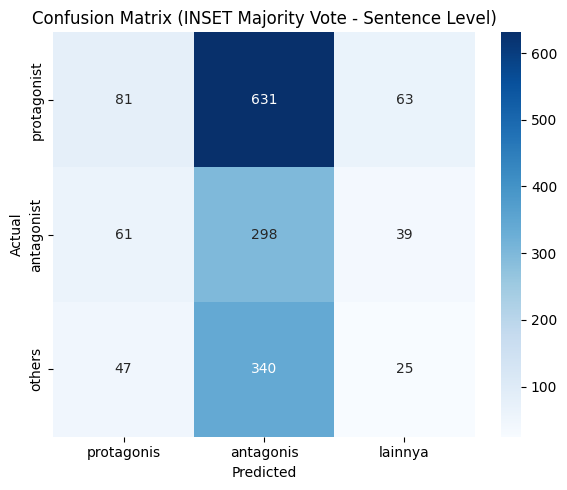


🏆 Lexicon-Based Summary:
Precision: 0.2868
Recall:    0.3046
F1-score:  0.2061
✅ Saved full classification report and summary metrics!


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate
true = df['type']
pred = df['lexicon_prediction']

# Generate classification report
report = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(save_dir, "classification_report.csv"))

# Print nicely
print("\n📊 Classification Report:")
print(report_df)

# Confusion Matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonis", "antagonis", "lainnya"])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (INSET Majority Vote - Sentence Level)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.show()

# Optional: print summary metrics
macro = report_df.loc["macro avg"]
print("\n🏆 Lexicon-Based Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")

# Save classification report to CSV
report_df.to_csv(os.path.join(save_dir, "classification_report.csv"))

# Also save summary (precision, recall, F1-score) to a TXT or CSV
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "summary_metrics.csv"), index=False)

print("✅ Saved full classification report and summary metrics!")



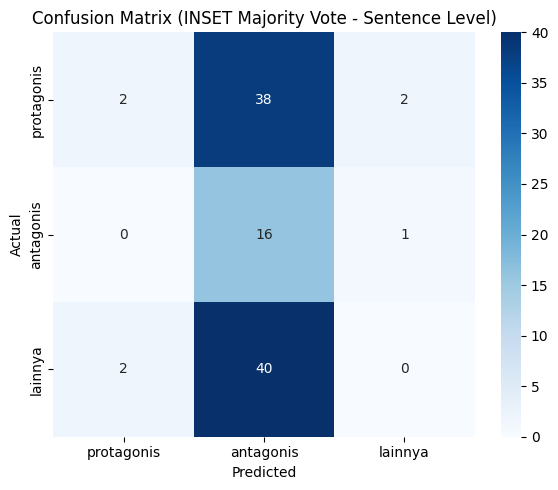


🏆 INSET (Filtered) Character-Level Summary:
Precision: 0.2234
Recall:    0.3296
F1-score:  0.1251


In [19]:
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load INSET predictions
df = pd.read_csv("inset_result/sentence_level_lexicon_pred.csv")

# Filter: primary sentences only
df_primary = df[df['is_primary_in_sentence'] == 1]

# Keep only characters with ≥ 2 primary mentions
mention_counts = df_primary.groupby(['story_id', 'person']).size().reset_index(name='primary_mentions')
valid_ids = mention_counts[mention_counts['primary_mentions'] >= 2][['story_id', 'person']]
df_filtered = df_primary.merge(valid_ids, on=['story_id', 'person'])

# Majority vote function
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

agg_df = df_filtered.groupby(['story_id', 'person']).agg({
    'type': 'first',
    'lexicon_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'lexicon_prediction': 'majority_prediction'}, inplace=True)

# Evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save results
save_dir = "inset_result"
report_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_character_report.csv"))

macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_summary.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(
    cm,
    index=["protagonis", "antagonis", "lainnya"],
    columns=["protagonis", "antagonis", "lainnya"]
)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (INSET Majority Vote - Sentence Level)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.show()


# Final print
print("\n🏆 INSET (Filtered) Character-Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


## AFINN (ID -> EN)

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Translating all sentences to English...


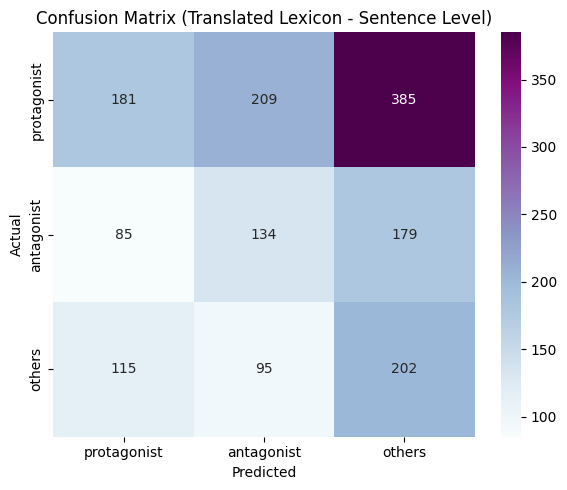


🏆 Translated Lexicon-Based Summary:
Precision: 0.3482
Recall:    0.3535
F1-score:  0.3256
📁 Saved in: wordsentinet


In [1]:
import os
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer
from afinn import Afinn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("").astype(str)

# 2. Load Indo→English translation model
id2en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-id-en")
id2en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-id-en")

def translate_id_to_en(text):
    inputs = id2en_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    translated = id2en_model.generate(**inputs)
    en_text = id2en_tokenizer.decode(translated[0], skip_special_tokens=True)
    return en_text

print("🔄 Translating all sentences to English...")
df['translated_en'] = df['text'].apply(translate_id_to_en)

# 3. Score using AFINN (English lexicon)
afinn = Afinn()

def classify_afinn(text):
    score = afinn.score(text)
    if score > 0:
        return "protagonist"
    elif score < 0:
        return "antagonist"
    else:
        return "others"

df['afinn_prediction'] = df['translated_en'].apply(classify_afinn)

# 4. Save results
save_dir = "wordsentinet"
os.makedirs(save_dir, exist_ok=True)
df.to_csv(os.path.join(save_dir, "sentence_level_translated_lexicon_pred.csv"), index=False)

# 5. Evaluate
true = df['type']
pred = df['afinn_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(save_dir, "classification_report.csv"))

# Summary metrics
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "summary_metrics.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonist", "antagonist", "others"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix (Translated Lexicon - Sentence Level)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.show()

# Final print
print("\n🏆 Translated Lexicon-Based Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")
print(f"📁 Saved in: {save_dir}")


In [3]:
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load with predictions (from wordsentinet output)
df = pd.read_csv("wordsentinet/sentence_level_translated_lexicon_pred.csv")

# Majority vote for each (story_id, person)
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

grouped = df.groupby(['story_id', 'person'])

agg_df = grouped.agg({
    'type': 'first',  # true label per character
    'afinn_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'afinn_prediction': 'majority_prediction'}, inplace=True)

# Evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save to wordsentinet
save_dir = "wordsentinet"
report_df.to_csv(os.path.join(save_dir, "majority_vote_character_report.csv"))

# Summary
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_summary.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonist", "antagonist", "others"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix (AFINN Majority Vote - Sentence Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_confusion_matrix.png"))
plt.show()

# Print final
print("\n🏆 Majority Vote - Character Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'wordsentinet/sentence_level_translated_lexicon_pred.csv'

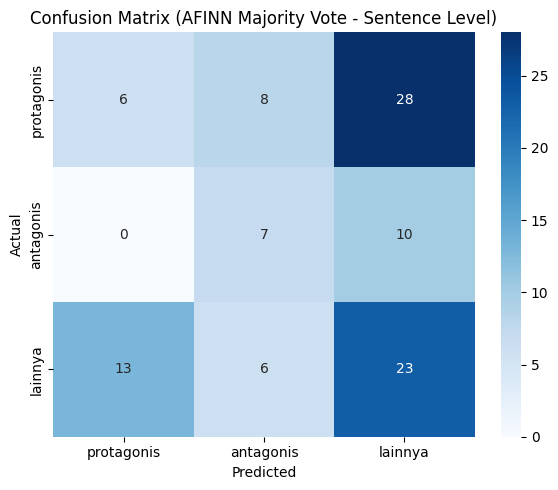


🏆 AFINN (Filtered) Character-Level Summary:
Precision: 0.3421
Recall:    0.3674
F1-score:  0.3372


In [22]:
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load AFINN predictions
df = pd.read_csv("afinn/sentence_level_translated_lexicon_pred.csv")

# Filter: primary sentences only
df_primary = df[df['is_primary_in_sentence'] == 1]

# Keep only characters with ≥ 2 primary mentions
mention_counts = df_primary.groupby(['story_id', 'person']).size().reset_index(name='primary_mentions')
valid_ids = mention_counts[mention_counts['primary_mentions'] >= 2][['story_id', 'person']]
df_filtered = df_primary.merge(valid_ids, on=['story_id', 'person'])

# Majority vote per character
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

agg_df = df_filtered.groupby(['story_id', 'person']).agg({
    'type': 'first',
    'afinn_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'afinn_prediction': 'majority_prediction'}, inplace=True)

# Evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save results
save_dir = "afinn"
report_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_character_report.csv"))

macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_summary.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(
    cm,
    index=["protagonis", "antagonis", "lainnya"],
    columns=["protagonis", "antagonis", "lainnya"]
)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (AFINN Majority Vote - Sentence Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_filtered_confusion_matrix.png"))
plt.show()

# Final print
print("\n🏆 AFINN (Filtered) Character-Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


## VADER (ID -> EN)

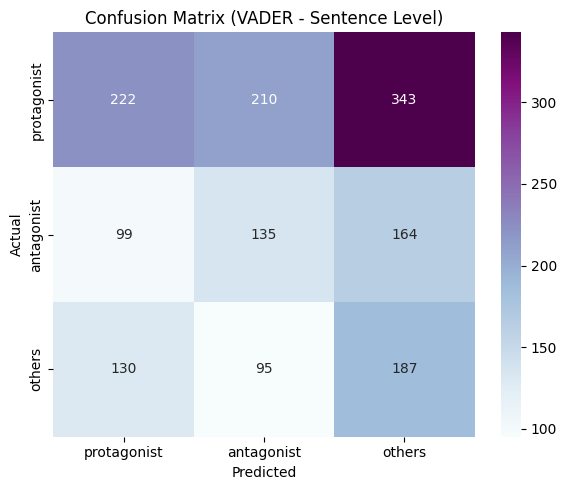


🏆 VADER Lexicon-Based Summary:
Precision: 0.3562
Recall:    0.3598
F1-score:  0.3408
📁 Saved in: VADER


In [3]:
import os
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load previously translated dataset
df = pd.read_csv("afinn/sentence_level_translated_lexicon_pred.csv")

# Drop old afinn prediction
if "afinn_prediction" in df.columns:
    df = df.drop(columns=["afinn_prediction"])

# 2. Score using VADER
analyzer = SentimentIntensityAnalyzer()

def classify_vader(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score > 0:
        return "protagonist"
    elif score < 0:
        return "antagonist"
    else:
        return "others"

df['vader_prediction'] = df['translated_en'].apply(classify_vader)

# 3. Save results
save_dir = "VADER"
os.makedirs(save_dir, exist_ok=True)
df.to_csv(os.path.join(save_dir, "sentence_level_translated_lexicon_pred.csv"), index=False)

# 4. Evaluate sentence-level
true = df['type']
pred = df['vader_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(save_dir, "classification_report.csv"))

# Summary
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "summary_metrics.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonist", "antagonist", "others"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix (VADER - Sentence Level)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.show()

# Final print
print("\n🏆 VADER Lexicon-Based Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")
print(f"📁 Saved in: {save_dir}")


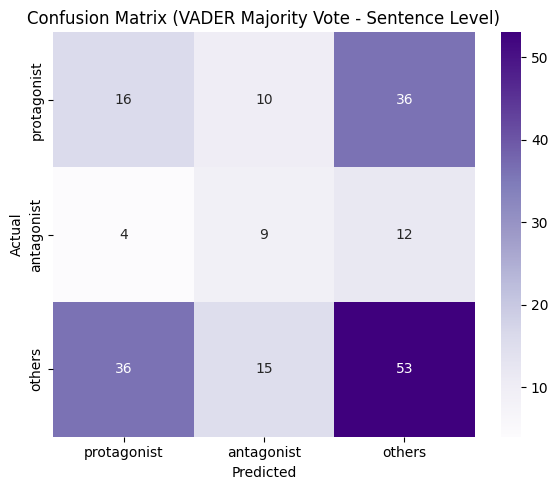


🏆 VADER Majority Vote - Character Level Summary:
Precision: 0.3584
Recall:    0.3759
F1-score:  0.3644


In [1]:
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load translated + VADER predictions
df = pd.read_csv("VADER/sentence_level_translated_lexicon_pred.csv")

# Majority vote function
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

# Group by (story_id, person) and vote
agg_df = df.groupby(['story_id', 'person']).agg({
    'type': 'first',  # true label per character
    'vader_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'vader_prediction': 'majority_prediction'}, inplace=True)

# Evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save to VADER folder
save_dir = "VADER"
report_df.to_csv(os.path.join(save_dir, "majority_vote_character_report.csv"), index=True)

# Summary metrics
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_summary.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonist", "antagonist", "others"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (VADER Majority Vote - Sentence Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_confusion_matrix.png"))
plt.show()

# Final print
print("\n🏆 VADER Majority Vote - Character Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


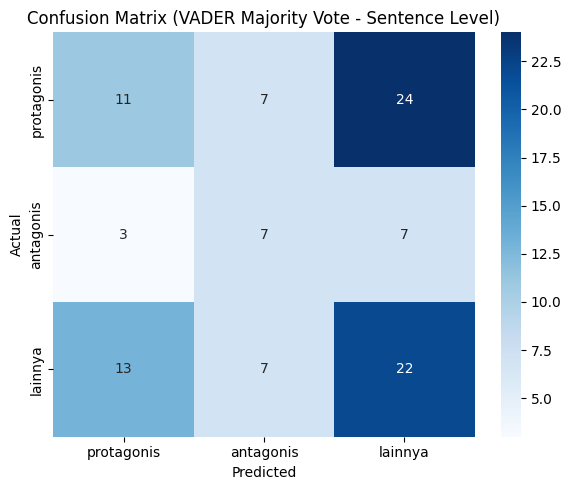


🏆 VADER (Filtered) Character-Level Summary:
Precision: 0.3853
Recall:    0.3992
F1-score:  0.3835


In [23]:
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load VADER predictions
df = pd.read_csv("VADER/sentence_level_translated_lexicon_pred.csv")

# Keep only primary sentences
df_primary = df[df['is_primary_in_sentence'] == 1]

# Count valid (story_id, person) with ≥ 2 primary mentions
mention_counts = df_primary.groupby(['story_id', 'person']).size().reset_index(name='primary_mentions')
valid_ids = mention_counts[mention_counts['primary_mentions'] >= 2][['story_id', 'person']]
df_filtered = df_primary.merge(valid_ids, on=['story_id', 'person'])

# Majority vote per character
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

agg_df = df_filtered.groupby(['story_id', 'person']).agg({
    'type': 'first',
    'vader_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'vader_prediction': 'majority_prediction'}, inplace=True)

# Evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save results
save_dir = "VADER"
report_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_character_report.csv"))

macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_summary.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(
    cm,
    index=["protagonis", "antagonis", "lainnya"],
    columns=["protagonis", "antagonis", "lainnya"]
)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (VADER Majority Vote - Sentence Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_filtered_confusion_matrix.png"))
plt.show()

# Final summary
print("\n🏆 VADER (Filtered) Character-Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


## Text Blob (ID -> EN)

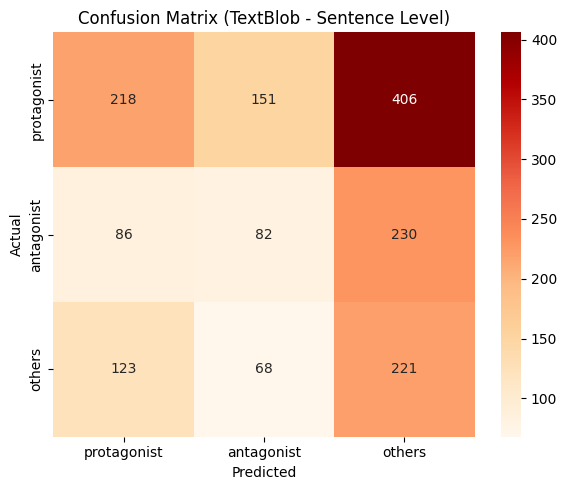


🏆 TextBlob Sentence-Level Summary:
Precision: 0.3469
Recall:    0.3412
F1-score:  0.3152
📁 Saved in: TEXTBLOB


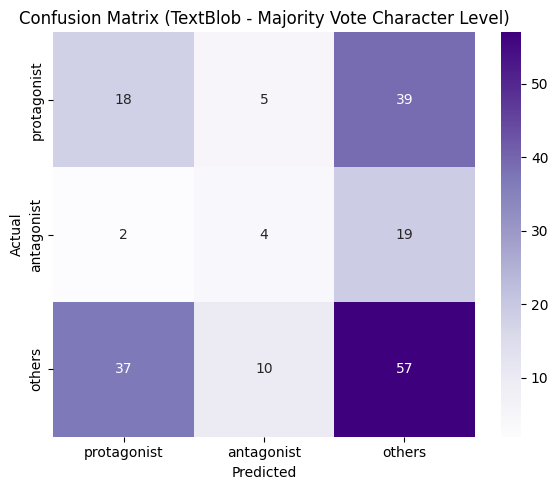


🏆 TextBlob Majority Vote - Character Level Summary:
Precision: 0.3407
Recall:    0.3328
F1-score:  0.3350


In [6]:
import os
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# 1. Load already-translated file
df = pd.read_csv("afinn/sentence_level_translated_lexicon_pred.csv")

# 2. Drop old AFINN prediction
if "afinn_prediction" in df.columns:
    df.drop(columns=["afinn_prediction"], inplace=True)

# 3. TextBlob polarity classification
def classify_textblob(text):
    score = TextBlob(str(text)).sentiment.polarity
    if score > 0:
        return "protagonist"
    elif score < 0:
        return "antagonist"
    else:
        return "others"

df['textblob_prediction'] = df['translated_en'].apply(classify_textblob)

# 4. Save sentence-level results
save_dir = "TEXTBLOB"
os.makedirs(save_dir, exist_ok=True)
df.to_csv(os.path.join(save_dir, "sentence_level_translated_lexicon_pred.csv"), index=False)

# 5. Sentence-level evaluation
true = df['type']
pred = df['textblob_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(save_dir, "classification_report.csv"))

# Sentence-level summary
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "summary_metrics.csv"), index=False)

# Confusion matrix (sentence-level)
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonist", "antagonist", "others"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='OrRd')
plt.title('Confusion Matrix (TextBlob - Sentence Level)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.show()

print("\n🏆 TextBlob Sentence-Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")
print(f"📁 Saved in: {save_dir}")

# 6. Majority vote per character
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

agg_df = df.groupby(['story_id', 'person']).agg({
    'type': 'first',
    'textblob_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'textblob_prediction': 'majority_prediction'}, inplace=True)

# Character-level evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(save_dir, "majority_vote_character_report.csv"))

# Summary
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_summary.csv"), index=False)

# Confusion matrix (character-level)
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(cm, index=["protagonist", "antagonist", "others"], columns=["protagonist", "antagonist", "others"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (TextBlob - Majority Vote Character Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_confusion_matrix.png"))
plt.show()

print("\n🏆 TextBlob Majority Vote - Character Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


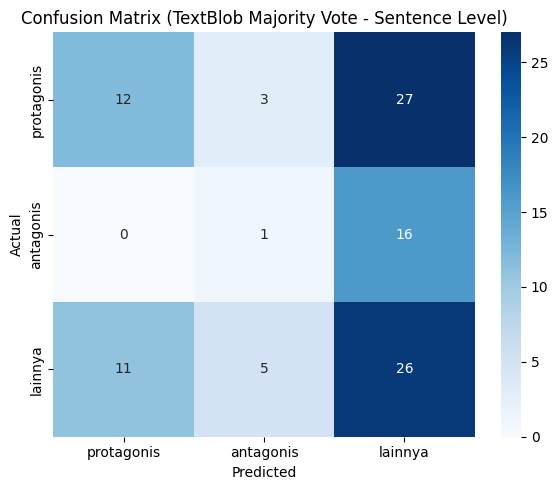


🏆 TextBlob (Filtered) Character-Level Summary:
Precision: 0.3366
Recall:    0.3212
F1-score:  0.3049


In [21]:
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load prediction CSV
df = pd.read_csv("TEXTBLOB/sentence_level_translated_lexicon_pred.csv")

# Filter: only primary sentences
df_primary = df[df['is_primary_in_sentence'] == 1]

# Count how many primary sentences per (story_id, person)
mention_counts = df_primary.groupby(['story_id', 'person']).size().reset_index(name='primary_mentions')

# Only keep those with ≥ 2 mentions
valid_ids = mention_counts[mention_counts['primary_mentions'] >= 2][['story_id', 'person']]
df_filtered = df_primary.merge(valid_ids, on=['story_id', 'person'])

# Majority vote logic
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

agg_df = df_filtered.groupby(['story_id', 'person']).agg({
    'type': 'first',
    'textblob_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'textblob_prediction': 'majority_prediction'}, inplace=True)

# Evaluate
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save to TEXTBLOB/
save_dir = "TEXTBLOB"
report_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_character_report.csv"))

# Summary
macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_summary.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(
    cm,
    index=["protagonis", "antagonis", "lainnya"],
    columns=["protagonis", "antagonis", "lainnya"]
)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (TextBlob Majority Vote - Sentence Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_filtered_confusion_matrix.png"))
plt.show()

# Print result
print("\n🏆 TextBlob (Filtered) Character-Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")


## SentiWordNet (ID -> EN)

In [11]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rayssa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rayssa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\rayssa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\sentiwordnet.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayssa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

🔍 Scoring all sentences using SentiWordNet...


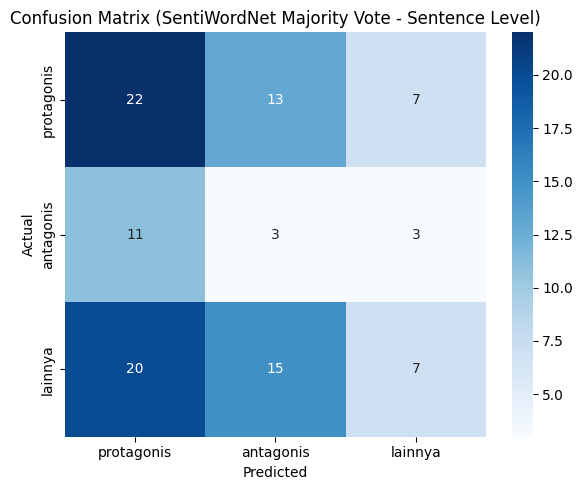


🏆 SentiWordNet (Filtered) Character-Level Summary:
Precision: 0.3079
Recall:    0.2890
F1-score:  0.2751
📁 Results saved in: SENTIWORDNET


In [20]:
import os
import pandas as pd
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# 1. Map POS tags to WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return None

# 2. Score sentence using SentiWordNet
def classify_sentiwordnet(text):
    if not text or pd.isna(text): return "others"
    tokens = word_tokenize(str(text))
    tagged = pos_tag(tokens)
    pos_score = neg_score = count = 0

    for word, tag in tagged:
        wn_tag = get_wordnet_pos(tag)
        if not wn_tag:
            continue
        synsets = wn.synsets(word, pos=wn_tag)
        if not synsets:
            continue
        synset = synsets[0]  # Use first synset (basic heuristic)
        swn_synset = swn.senti_synset(synset.name())
        pos_score += swn_synset.pos_score()
        neg_score += swn_synset.neg_score()
        count += 1

    if count == 0:
        return "others"

    final_score = pos_score - neg_score
    if final_score > 0:
        return "protagonist"
    elif final_score < 0:
        return "antagonist"
    else:
        return "others"

# 3. Load translated sentences
df = pd.read_csv("afinn/sentence_level_translated_lexicon_pred.csv")
df.drop(columns=["afinn_prediction"], inplace=True, errors="ignore")

# 4. Predict using SentiWordNet
print("🔍 Scoring all sentences using SentiWordNet...")
df['sentiwordnet_prediction'] = df['translated_en'].apply(classify_sentiwordnet)

# 5. Save sentence-level output
save_dir = "SENTIWORDNET"
os.makedirs(save_dir, exist_ok=True)
df.to_csv(os.path.join(save_dir, "sentence_level_translated_lexicon_pred.csv"), index=False)

# 6. Filter: only is_primary + ≥ 2 mentions
df_primary = df[df['is_primary_in_sentence'] == 1]
mention_counts = df_primary.groupby(['story_id', 'person']).size().reset_index(name='primary_mentions')
valid_ids = mention_counts[mention_counts['primary_mentions'] >= 2][['story_id', 'person']]
df_filtered = df_primary.merge(valid_ids, on=['story_id', 'person'])

# 7. Majority vote
def majority_vote(predictions):
    return Counter(predictions).most_common(1)[0][0]

agg_df = df_filtered.groupby(['story_id', 'person']).agg({
    'type': 'first',
    'sentiwordnet_prediction': lambda x: majority_vote(x)
}).reset_index()

agg_df.rename(columns={'sentiwordnet_prediction': 'majority_prediction'}, inplace=True)

# 8. Evaluation
true = agg_df['type']
pred = agg_df['majority_prediction']

report_dict = classification_report(true, pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_character_report.csv"), index=True)

macro = report_df.loc["macro avg"]
summary_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score"],
    "Score": [macro["precision"], macro["recall"], macro["f1-score"]]
})
summary_df.to_csv(os.path.join(save_dir, "majority_vote_filtered_summary.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(true, pred, labels=["protagonist", "antagonist", "others"])
cm_df = pd.DataFrame(
    cm,
    index=["protagonis", "antagonis", "lainnya"],
    columns=["protagonis", "antagonis", "lainnya"]
)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (SentiWordNet Majority Vote - Sentence Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "majority_vote_filtered_confusion_matrix.png"))
plt.show()

# 9. Print summary
print("\n🏆 SentiWordNet (Filtered) Character-Level Summary:")
print(f"Precision: {macro['precision']:.4f}")
print(f"Recall:    {macro['recall']:.4f}")
print(f"F1-score:  {macro['f1-score']:.4f}")
print(f"📁 Results saved in: {save_dir}")


In [13]:
import pandas as pd
import os

# Folder names and their display names
models = {
    "VADER": "VADER",
    "afinn": "AFINN",
    "TEXTBLOB": "TextBlob",
    "SENTIWORDNET": "SentiWordNet",
    "inset_result": "INSET"
}

# Collect results
results = []

for folder, model_name in models.items():
    path = os.path.join(folder, "majority_vote_filtered_summary.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        precision = df.loc[df['Metric'] == 'Precision', 'Score'].values[0]
        recall = df.loc[df['Metric'] == 'Recall', 'Score'].values[0]
        f1 = df.loc[df['Metric'] == 'F1-score', 'Score'].values[0]
        results.append({
            "Model": model_name,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        })
    else:
        print(f"⚠️ File not found: {path}")

# Convert to DataFrame and sort by F1
leaderboard_df = pd.DataFrame(results)
leaderboard_df = leaderboard_df.sort_values(by="F1-score", ascending=False)

# Save to CSV
leaderboard_df.to_csv("lexicon_filtered_leaderboard.csv", index=False)
print("✅ Leaderboard saved as 'lexicon_filtered_leaderboard.csv'")
print(leaderboard_df)


✅ Leaderboard saved as 'lexicon_filtered_leaderboard.csv'
          Model  Precision    Recall  F1-score
0         VADER   0.385278  0.399160  0.383473
1         AFINN   0.342057  0.367414  0.337248
2      TextBlob   0.336554  0.321195  0.304874
3  SentiWordNet   0.307878  0.288982  0.275149
4         INSET   0.223404  0.329599  0.125082
